<a href="https://colab.research.google.com/github/U-11-Agar/timeseries-notebook/blob/main/deep_lstm_gradient_explode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Dense, Bidirectional, LeakyReLU,Dropout,BatchNormalization,Attention,Input
from keras.losses import mean_squared_error
from keras.metrics import RootMeanSquaredError
from keras.initializers import RandomNormal
from keras.callbacks import Callback
from keras.optimizers import Adam
# Define the LSTM model architecture

# Define the symbol for the stock to trade
symbol = 'ADANIENT.NS'

# Download historical stock prices for the given symbol
df = yf.download(symbol, start="2020-01-01")
df.dropna(inplace=True, axis=0)
# df.set_index('Date', inplace=True)
# Replace zero volume values with the mean volume
df.loc[(df == 0).any(axis=1), 'Volume'] = df['Volume'].mean()
df.loc[(df == 0).any(axis=1), 'Close'] = df['Close'].mean()
df.loc[(df == 0).any(axis=1), 'Open'] = df['Open'].mean()


# Define the trading signals dataframe
trading_signals = pd.DataFrame(columns=['signal', 'price'])

# Define the initial trading signal as 'Hold'
trading_signals.loc[df.index[0], 'signal'] = 'Hold'
trading_signals.loc[df.index[0], 'price'] = df['Close'][0]


def data_reshape(x_train, y_train, n_steps, n_features, X, y):
    # X = []
    # for i in np.arange(n_steps, len(data)):
    #     X.append(data.iloc[i-n_steps:i, :])
    # X = np.array(X)
    # X = np.reshape(X, (X.shape[0], n_steps, n_features))
    for i in np.arange(n_steps, len(x_train)):
        X.append(x_train.iloc[i-n_steps:i, :])
        y.append(y_train.iloc[i])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], n_steps, n_features))
    return X, y

# Define the trading strategy function


def trading_strategy(model, X,y_pred):
    y_pred = model.predict(X)
    return y_pred


# class PrintGradientsCallback(Callback):
#     def __init__(self, model):
#         super(PrintGradientsCallback, self).__init__()
#         self.model = model

#     def on_train_batch_end(self, batch, logs=None):
#         weights = self.model.trainable_weights
#         gradients = self.model.optimizer.get_gradients(self.model.total_loss, weights)
#         gradients = K.batch_get_value(gradients)
#         for weight, gradient in zip(weights, gradients):
#             print(weight.name, gradient)
# Create an instance of the callback
# Train the model with the callback




def lstm_model(n_steps, n_features):
    input = Input(shape=(n_steps, n_features))
    x = Bidirectional(LSTM(units=120, return_sequences=True, input_shape=(n_steps, n_features), use_bias=True, dropout=0.05, recurrent_dropout=0.025, activation='linear',kernel_initializer=RandomNormal(mean=0.0, stddev=0.1), bias_initializer=RandomNormal(mean=0.0, stddev=0.1)))(input)
    x = Attention()([x, x])
    x = BatchNormalization()(x)

    # Add deep layers
    for i in range(5):
        x = Bidirectional(LSTM(units=240, use_bias=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.025, activation='linear',kernel_initializer=RandomNormal(mean=0.0, stddev=0.1), bias_initializer=RandomNormal(mean=0.0, stddev=0.1)))(x)
        x = Attention()([x, x])
        x = BatchNormalization()(x)

    x = Bidirectional(LSTM(units=120, return_sequences=False, use_bias=True, dropout=0.05, recurrent_dropout=0.025, activation='linear', kernel_initializer=RandomNormal(mean=0.0, stddev=0.1), bias_initializer=RandomNormal(mean=0.0, stddev=0.1)))(x)
    x = Attention()([x, x])
    x = BatchNormalization()(x)
    x = Dense(units=1, activation='linear')(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer='Adam', loss=mean_squared_error, metrics=[RootMeanSquaredError()])
    # model.compile(optimizer=Adam(clipnorm=1.0), loss=mean_squared_error, metrics=[RootMeanSquaredError()])
    return model




def create_data_model(dataframe, data_model):
    data_model['Close'] = dataframe['Close']
    data_model['Open'] = dataframe['Open']
    data_model['pct_change_open'] = dataframe['Open'].pct_change()
    data_model['pct_change_close'] = dataframe['Close'].pct_change()
    data_model['HO'] = dataframe['High']-dataframe['Open']
    data_model['HC'] = dataframe['High']-dataframe['Close']
    data_model['CL'] = dataframe['Close']-dataframe['Low']
    data_model['OL'] = dataframe['Open']-dataframe['Low']
    data_model['HL'] = dataframe['High']-dataframe['Low']
    data_model['OC'] = dataframe['Open']-dataframe['Close']
    data_model['pct_change_vol'] = dataframe['Volume'].pct_change()
    data_model['Volume'] = (dataframe['Volume']-min(dataframe['Volume']))/max(dataframe['Volume'])
    # Example usage
    # stock_data = pd.read_csv('stock_data.csv')
    # stock_data['Date'] = pd.to_datetime(dataframe['Date'])
    ma_df = calculate_moving_average(dataframe)
    rsi_df = calculate_relative_strength_index(dataframe)
    bb_df = calculate_bollinger_bands(dataframe)
    stochastic_df = calculate_stochastic_oscillator(dataframe)
    macd_df=MACD(dataframe)
    # Combine all the indicators into one DataFrame
    indicators_df = pd.concat([ma_df, rsi_df, bb_df, stochastic_df,macd_df], axis=1)
    data_model[indicators_df.columns] = indicators_df
    data_model.dropna(inplace=True, axis=0,how='any')
    return data_model
    # print(indicators_df.head())
# the reseon to chose this as a variable to input my lstm as change in volume of a stock can show how people are responding to that campany


def calculate_moving_average(dataframe, window=14):
    ma = dataframe['Close'].rolling(window=window).mean()
    return pd.DataFrame({'MA': ma})


def calculate_relative_strength_index(dataframe, window=7):
    delta = dataframe['Close'].diff()
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)
    ema_up = up.ewm(com=window-1, adjust=False).mean()
    ema_down = down.ewm(com=window-1, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    return pd.DataFrame({'RSI': rsi})

def MACD(dataframe, fast=12, slow=26, signal=9):
    # Calculate the short-term exponential moving average (EMA)
    ema_fast = dataframe['Close'].ewm(span=fast, min_periods=fast,adjust=False).mean()

    # Calculate the long-term exponential moving average (EMA)
    ema_slow = dataframe['Close'].ewm(span=slow, min_periods=slow,adjust=False).mean()

    # Calculate the MACD line
    macd_line = ema_fast - ema_slow

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal, min_periods=signal,adjust=False).mean()

    # Calculate the MACD histogram
    macd_hist = macd_line - signal_line

    # print(macd_line) 
    # print(signal_line) 
    # print(macd_hist)  
    return pd.DataFrame({'macd_hist':macd_hist,'macd_line':macd_line,'signal_line':signal_line})

def calculate_bollinger_bands(dataframe, window=20):
    ma = dataframe['Close'].rolling(window=window).mean()
    std = dataframe['Close'].rolling(window=window).std()
    upper_band = ma + (2 * std)
    lower_band = ma - (2 * std)
    return pd.DataFrame({'Upper Band': upper_band, 'Lower Band': lower_band})


def calculate_stochastic_oscillator(dataframe, window=14):
    low = dataframe['Low'].rolling(window=window).min()
    high = dataframe['High'].rolling(window=window).max()
    k = 100 * ((dataframe['Close'] - low) / (high - low))
    d = k.rolling(window=3).mean()
    return pd.DataFrame({'%K': k, '%D': d})


data_model = pd.DataFrame()
data_model = create_data_model(df, data_model)
# Define the number of time steps and features for the LSTM model
n_steps = 2
n_features = data_model.shape[1]

# model = Sequential()
model = lstm_model(n_steps,n_features)
# Train the LSTM model
X_train = data_model[data_model.columns]
# y_train = data_model[['Open', 'Close']]
y_train = data_model['Close']
# X_train.dropna(inplace=True,axis=0)
# y_train.dropna(inplace=True,axis=0)
X = []
y = []
X, y = data_reshape(X_train, y_train, n_steps, n_features, X, y)

# print_gradients_callback = PrintGradients()
history = model.fit(X, y, epochs=40, batch_size=3)
# history=model.fit(X, y, epochs=20, batch_size=14, callbacks=[print_gradients_callback])

# Use the LSTM model to generate trading signals
y_pred = []
y_pred = trading_strategy(model, X,y_pred)

# Define the trading rules based on the predicted values
for i in range(len(X_train)-n_steps):
    if y_pred[i] > X_train['Close'][i+n_steps]:
        trading_signals.loc[X_train.index[i+n_steps], 'signal'] = 'Buy'
        trading_signals.loc[X_train.index[i+n_steps],
                            'price'] = X_train['Close'][i+n_steps]
    elif y_pred[i] < X_train['Close'][i+n_steps]:
        trading_signals.loc[X_train.index[i+n_steps], 'signal'] = 'Sell'
        trading_signals.loc[X_train.index[i+n_steps],
                            'price'] = X_train['Close'][i+n_steps]
    else:
        trading_signals.loc[X_train.index[i+n_steps], 'signal'] = 'Hold'
        trading_signals.loc[X_train.index[i+n_steps],
                            'price'] = X_train['Close'][i+n_steps]
print(trading_signals)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/40


In [ ]:
y_pred

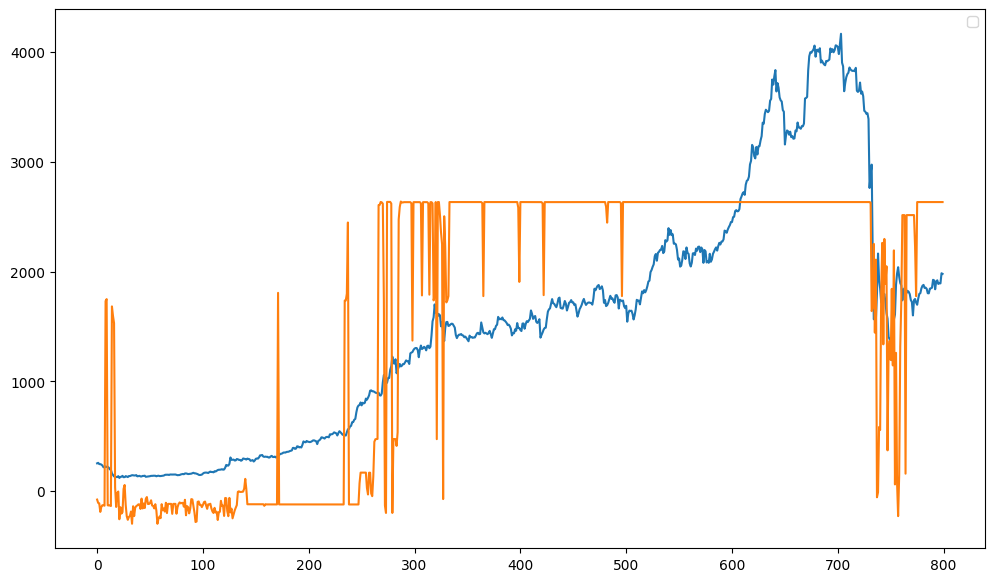

In [14]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,7))
plt.plot(y)
plt.plot(y_pred)
plt.legend()
plt.show()

In [13]:
data_model.isnull().any()

Close               False
Open                False
pct_change_open     False
pct_change_close    False
HO                  False
HC                  False
CL                  False
OL                  False
HL                  False
OC                  False
pct_change_vol      False
Volume              False
MA                  False
RSI                 False
Upper Band          False
Lower Band          False
%K                  False
%D                  False
macd_hist           False
macd_line           False
signal_line         False
dtype: bool

In [5]:
data_model

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,209.000000,210.449997,206.649994,207.850006,206.116074,1553127.0
2020-01-02,208.000000,213.199997,207.500000,211.199997,209.438126,2991937.0
2020-01-03,210.250000,212.350006,205.800003,208.300003,206.562302,2512421.0
2020-01-06,207.750000,207.750000,197.750000,199.550003,197.885315,4353179.0
2020-01-07,200.550003,205.699997,200.550003,204.050003,202.347778,2966120.0
...,...,...,...,...,...,...
2023-05-03,1919.000000,1940.000000,1785.349976,1839.000000,1839.000000,5849432.0
2023-05-04,1839.050049,1935.000000,1839.050049,1911.250000,1911.250000,4842127.0
2023-05-05,1954.800049,1955.000000,1903.150024,1920.300049,1920.300049,6137744.0


In [10]:
def MACD(dataframe, fast=12, slow=26, signal=9):
    # Calculate the short-term exponential moving average (EMA)
    ema_fast = dataframe['Close'].ewm(span=fast, min_periods=fast,adjust=True).mean()

    # Calculate the long-term exponential moving average (EMA)
    ema_slow = dataframe['Close'].ewm(span=slow, min_periods=slow).mean()

    # Calculate the MACD line
    macd_line = ema_fast - ema_slow

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal, min_periods=signal).mean()

    # Calculate the MACD histogram
    macd_hist = macd_line - signal_line

    print(macd_line) 
    # print(signal_line) 
    # print(macd_hist)  

MACD(df)

Date
2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
                ...    
2023-05-03    12.495173
2023-05-04    16.238553
2023-05-05    19.708287
2023-05-08    19.585615
2023-05-09    20.327280
Name: Close, Length: 832, dtype: float64


In [11]:
while(True):
  

SyntaxError: ignored

In [11]:
import pandas as pd
import numpy as np

# create a dataframe with missing values
df = pd.DataFrame({'A': [1, 2, np.nan, np.nan,7],
                   'B': [np.nan, 5, np.nan, np.nan,8],
                   'C': [np.nan, np.nan, 3, 4,9],
                   'D': [6, 7, 8, 9,0]})

# remove rows with any missing values
df_any = df.dropna(how='any')
print(df_any)
# Output: 
#      A    B    C  D
# 3  NaN  NaN  4.0  9

# remove rows with all missing values
df_all = df.dropna(how='all')
# print(df_all)
# Output:
#      A    B    C  D
# 0  1.0  NaN  NaN  6
# 1  2.0  5.0  NaN  7
# 2  NaN  NaN  3.0  8
# 3  NaN  NaN  4.0  9

     A    B    C  D
4  7.0  8.0  9.0  0
